In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%cd drive/MyDrive/kaggle/SeoulBikeDemandForecasting/notebook

/content/drive/MyDrive/kaggle/SeoulBikeDemandForecasting/notebook


In [3]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import  LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV,  cross_val_score

In [4]:
data = pd.read_csv("../data/SeoulBikeData.csv", encoding= 'unicode_escape')

## (1) Problem Description

This is the data that stores the number of bicycle rentals in Seoul every hour from January 12, 2017 to November 30, 2018. Our goal is to predict the number of bicycle rentals on the last 28 days given the data.

## (2) Exploratory Data Analysis

In [5]:
data_new = pd.DataFrame(index = data.columns)
data_new['DataType'] = data.dtypes
data_new['num_data'] = data.count()
data_new['NaN'] = data.isnull().sum()

data_new

,DataType,num_data,NaN
Date,object,8760,0
Rented Bike Count,int64,8760,0
Hour,int64,8760,0
Temperature(°C),float64,8760,0
Humidity(%),int64,8760,0
Wind speed (m/s),float64,8760,0
Visibility (10m),int64,8760,0
Dew point temperature(°C),float64,8760,0
Solar Radiation (MJ/m2),float64,8760,0
Rainfall(mm),float64,8760,0


(1) There are 8,760 data with 14 features in the table. The features associated with time are Date, Hour, and Seasons.

In [6]:
data['Date'] = pd.to_datetime(data['Date'])
data['day'] = data['Date'].dt.day
data['month'] = data['Date'].dt.month
data['year'] = data['Date'].dt.year
data.drop(['Date'], axis = 1, inplace = True)

In [7]:
data.groupby("Functioning Day")['Rented Bike Count'].sum()

Functioning Day
No           0
Yes    6172314
Name: Rented Bike Count, dtype: int64

As the number of bikes is zero on a non-functioning day, the corresponding data is removed from the dataframe

In [8]:
data = data.drop(data[data['Functioning Day'] == 'No'].index).reset_index(drop = True)

(1) Apply LabelEncoder to the categorical data.

(2) The last 28 days and 24 hours data is used as test data and the rest of the data is used as learning data.

In [9]:
pp_data = data.apply(LabelEncoder().fit_transform)
X = pp_data.drop('Rented Bike Count',axis=1)
y = pp_data['Rented Bike Count']

train, test = pp_data.iloc[:-678], pp_data.iloc[-678:]
x_train, y_train = train.drop(['Rented Bike Count'], axis = 1), train['Rented Bike Count']
x_test, y_test   = test.drop(['Rented Bike Count'], axis = 1), test['Rented Bike Count']

## (3) Modeling (Regression)

Set the LightGBM Regressor as the baseline and select the features through recursive feature elimination (RFE). 

And use GridSearchCV to tune the hyperparameters.

In [10]:
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor

param_grid = [{'estimator__n_estimators': [50, 100, 150, 200], 
               'estimator__learning_rate': [0.1, 0.5, 0.01, 0.05]}] 

start_time = time.time()
clf = LGBMRegressor(random_state = 42, n_estimators = 100, learning_rate = 0.01)
selector = RFECV(clf, step = 1, cv = 5, min_features_to_select = 5)
model = GridSearchCV(selector, param_grid, cv = 5)
#model = LGBMRegressor()
model.fit(x_train, y_train)
score = model.score(x_test, y_test)
total_time = time.time() - start_time

print(f"Train and Inference time: {total_time:.2f} seconds, R2 Score: {score:.2f}")

Train and Inference time: 1031.04 seconds, R2 Score: 0.70


Plot the prediction and ground truth in the same graph.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


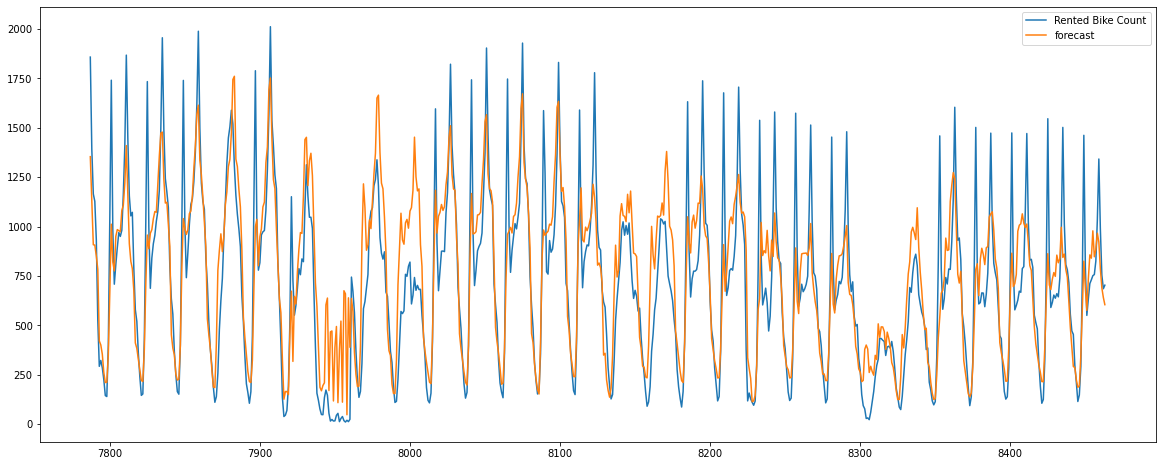

In [11]:
start_index, end_index = 7787, 8464
estimator = model.best_estimator_
y_pred = estimator.predict(x_test)
pp_data['forecast'] = 0.0
pp_data['forecast'][start_index:end_index+1] = y_pred
pp_data[start_index:end_index][['Rented Bike Count', 'forecast']].plot(figsize=(20, 8))

## (4) Modeling (Seasonal ARIMA)

As bike demand is time series data, it can be modelled as ARIMA. In order to do, I first check whether the data is stationary or not.

In [12]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

In [13]:
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(20, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

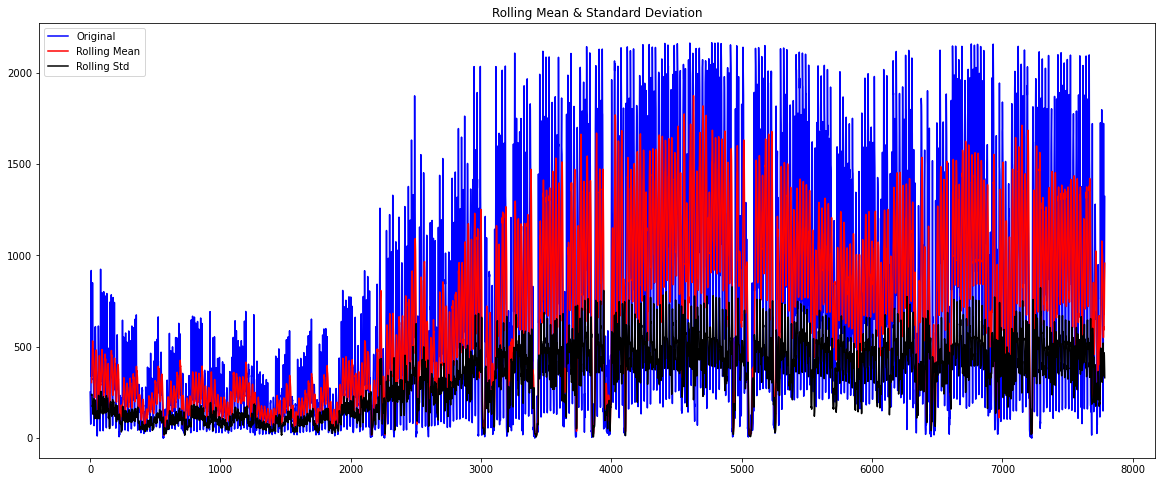

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -5.727527e+00
p-value                        6.717317e-07
#Lags Used                     2.000000e+01
Number of Observations Used    7.766000e+03
Critical Value (1%)           -3.431192e+00
Critical Value (5%)           -2.861912e+00
Critical Value (10%)          -2.566968e+00
dtype: float64


In [14]:
test_stationarity(y_train)

Although the data passed the ACF test, it is necessary to make it uniform because the average and variance fluctuations are large.

Therefore, I apply log and differencing to the data.

In [15]:
log_y_train = pd.Series(np.where(pp_data['Rented Bike Count'][:start_index] > 0, np.log(pp_data['Rented Bike Count'][:start_index]), 0))
log_y_test  = pd.Series(np.where(pp_data['Rented Bike Count'][start_index:] > 0, np.log(pp_data['Rented Bike Count'][start_index:]), 0))

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


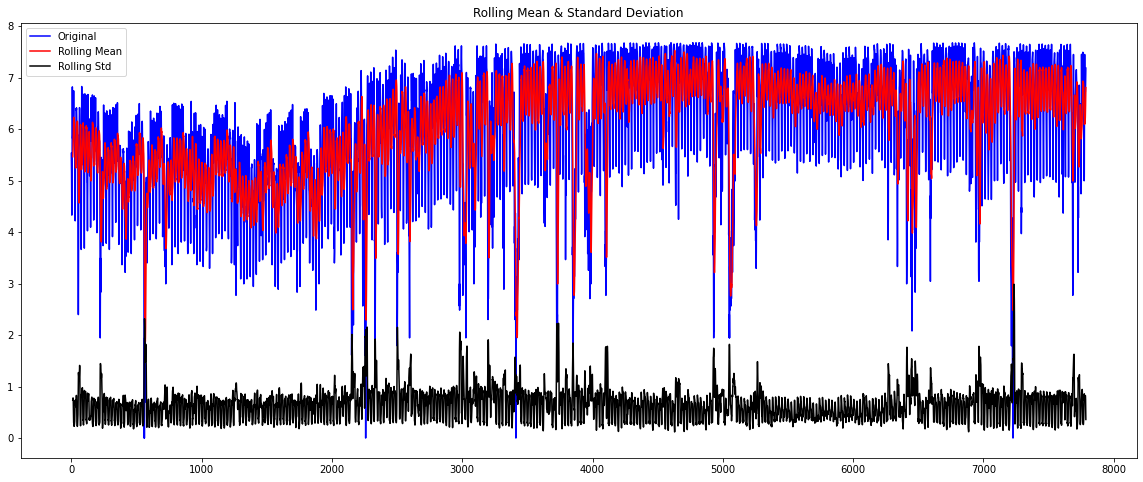

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -7.011621e+00
p-value                        6.898264e-10
#Lags Used                     2.000000e+01
Number of Observations Used    7.766000e+03
Critical Value (1%)           -3.431192e+00
Critical Value (5%)           -2.861912e+00
Critical Value (10%)          -2.566968e+00
dtype: float64


In [16]:
test_stationarity(log_y_train)

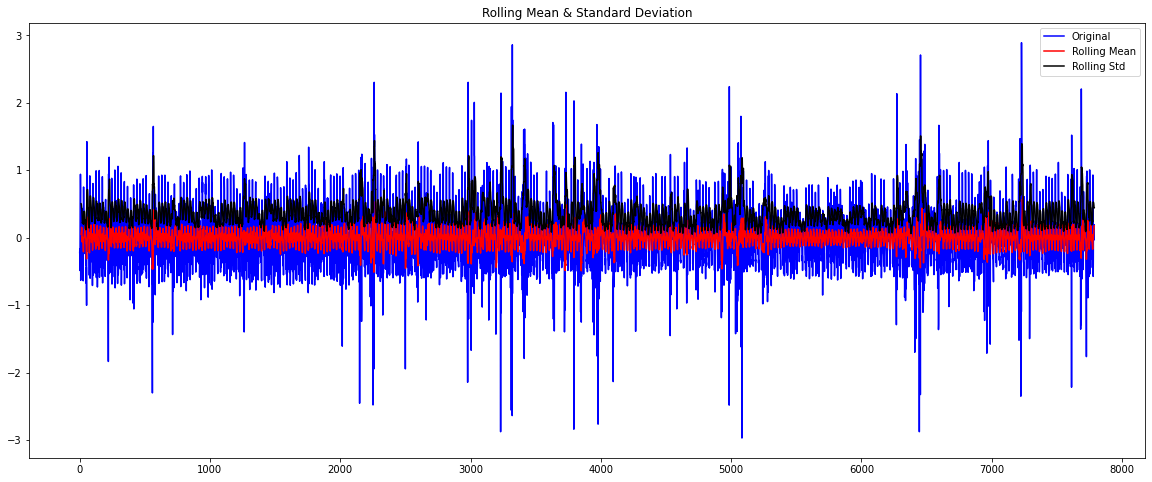

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                  -46.021398
p-value                           0.000000
#Lags Used                       20.000000
Number of Observations Used    7765.000000
Critical Value (1%)              -3.431192
Critical Value (5%)              -2.861912
Critical Value (10%)             -2.566968
dtype: float64


In [17]:
log_y_train_diff = log_y_train - log_y_train.shift(1)
test_stationarity(log_y_train_diff[1:])

After log and differencing, the mean and std seems uniform and p-value is low. Therefore, we can model the data as ARIMA with the setting.

Due to the memory limit in Colab, I use 'auto_arima' (automatically find the hyperparameters of ARIMA) in the Virtual Machine with higher RAM. And the best hyperparameters are order = (1, 0, 1) and seasonal_order = (1, 1, 1, 24)

In [19]:
ext_var_list = ['Hour', 'Temperature(°C)', 'Humidity(%)',
                'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)',
                'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
                'Holiday', 'day', 'month', 'year']

exog_data = pp_data[ext_var_list]

start_time = time.time()
sarimax_mod23 = sm.tsa.statespace.SARIMAX(endog = log_y_train,
                                          exog = exog_data[:start_index],  
                                          trend='n', order=(1, 0, 1), seasonal_order=(1,1,1,24)).fit()
total_time = time.time() - start_time

print(f"Train time (not including hyperparameter search): {total_time:.2f}")

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Train time: 537.12


In [20]:
start_time = time.time()
pp_data['forecast'][start_index:end_index+1] = np.exp(sarimax_mod23.predict(start = start_index, end= end_index, exog = exog_data[start_index:],  dynamic= True))
total_time = time.time() - start_time

print(f"Inference time: {total_time:.2f}")

Inference time: 0.27


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


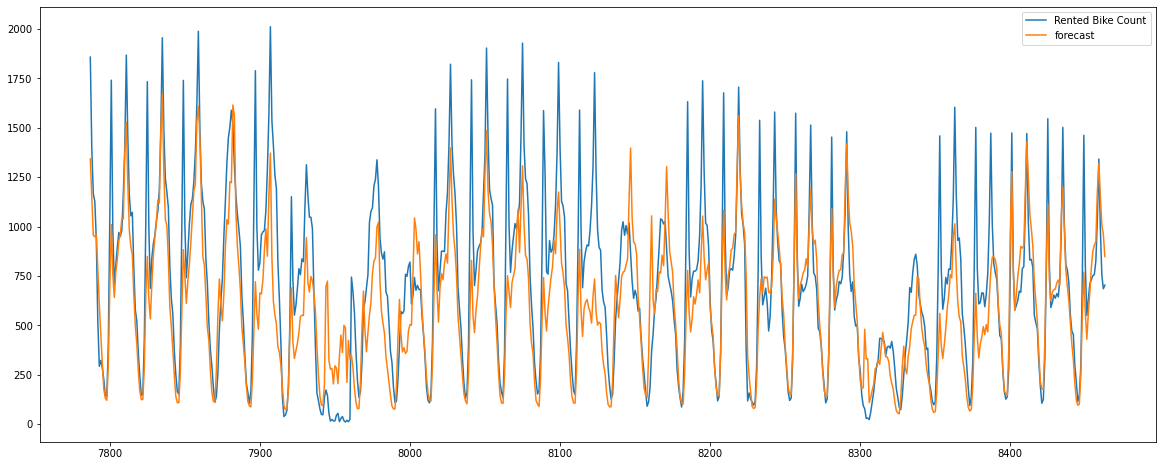

In [21]:
pp_data[start_index:end_index][['Rented Bike Count', 'forecast']].plot(figsize=(20, 8))

In [22]:
from sklearn.metrics import r2_score

y_test = pp_data[start_index:end_index]['Rented Bike Count']
y_pred = pp_data[start_index:end_index]['forecast']
print(f"Model R-Square : {r2_score(y_test,y_pred)*100:.2f}%")

Model R-Square : 63.53%


## (5) Conclusion

|   | LightGBM  | SARIMA  | 
|---|---|---|
|R2 score   | 70.03  | 63.53  |  
|Train + Inference Time   | 1031 (s)  | 1642 (s)  | 
|   |   |   |  

Seasonal ARIMA requires more training time to find the optimal parameters, and gets less R2 score than Regression method. There may be a better hyperparameter for SARIMA, but it took a long time to find it. Therefore, it seems better to use Regression model in terms of training time.